# Environment

In [1]:
# Import required libraries
import loompy
import numpy as np
import pandas as pd
import gc  # for garbage collection
import os
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3_dev/Mousebrain')

# Set plotting style
plt.style.use('default')  # Use default matplotlib style
sns.set_theme()  # Apply seaborn styling
sns.set_palette("husl")

In [2]:
loom_path = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3_dev/Mousebrain/DATA/dev_all.loom"

In [3]:
# Verify file exists
print(f"File exists: {os.path.exists(loom_path)}")
print(f"File size: {os.path.getsize(loom_path) / (1024**3):.2f} GB")

File exists: True
File size: 9.56 GB


# Define functions

**Column attributes**
- Age: object
- BTSNE: float64
- CellCycle: float64
- CellID: object
- Cell_Conc: int64
- Chemistry: object
- ChipID: object
- Class: object
- ClusterName: object
- Clusters: int64
- Date_Captured: object
- DonorID: object
- DoubletFinderPCA: float64
- HPF: float64
- HPF_LogPP: float64
- HPF_theta: float64
- IsCycling: uint8
- Label: object
- Location_E9_E11: object
- NCellsCluster: int64
- NGenes: float64
- Num_Pooled_Animals: int64
- PCA: float64
- PCR_Cycles: int64
- Plug_Date: object
- Project: object
- PseudoAge: float64
- PseudoTissue: object
- Region: object
- SampleID: object
- SampleName: object
- Sample_Index: object
- Sex: object
- Species: object
- Split: int64
- Strain: object
- Subclass: object
- TSNE: float64
- Target_Num_Cells: float64
- Tissue: object
- TotalUMI: float64
- Transcriptome: object
- UMAP: float32
- UMAP3D: float32
- cDNA_Lib_Ok: object
- ngperul_cDNA: object


In [10]:
def get_srrm3_data(loom_path: str) -> Dict:
    """Extract Srrm3-related data from the loom file"""
    with loompy.connect(loom_path) as ds:
        # Find Srrm3 gene index
        gene_indices = np.where(ds.ra.Gene == 'Srrm3')[0]
        if len(gene_indices) == 0:
            raise ValueError("Srrm3 gene not found in dataset")
        srrm3_idx = gene_indices[0]
        
        # Extract Srrm3 expression data
        srrm3_expr = ds[srrm3_idx, :]
        
        # Extract relevant metadata
        metadata = {
            'Age': ds.ca.Age,
            'Tissue': ds.ca.Tissue,
            'Sex': ds.ca.Sex,
            'Subclass': ds.ca.Subclass,
            'Class': ds.ca.Class,
            'Region': ds.ca.Region,
            'PseudoAge': ds.ca.PseudoAge,
            'Expression': srrm3_expr
        }
        
        return metadata

def plot_temporal_expression(data: Dict):
    """Plot Srrm3 expression across developmental time"""
    plt.figure(figsize=(12, 6))
    
    # Create violin plot
    df = pd.DataFrame({
        'PseudoAge': data['PseudoAge'],
        'Expression': data['Expression']
    })
    
    sns.violinplot(data=df, x='PseudoAge', y='Expression')
    plt.title('Srrm3 Expression Across Developmental Time')
    plt.xlabel('Pseudo Age')
    plt.ylabel('Expression Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('plots/srrm3_temporal_expression.pdf')
    plt.close()

def plot_cell_type_expression(data: Dict):
    """Plot Srrm3 expression across cell types"""
    plt.figure(figsize=(15, 6))
    
    # Create box plot
    df = pd.DataFrame({
        'Cell Type': data['Class'],
        'Expression': data['Expression']
    })
    
    # Calculate mean expression per cell type for sorting
    cell_type_means = df.groupby('Cell Type')['Expression'].mean().sort_values(ascending=False)
    
    sns.boxplot(data=df, x='Cell Type', y='Expression', order=cell_type_means.index)
    plt.title('Srrm3 Expression Across Cell Types')
    plt.xlabel('Cell Type')
    plt.ylabel('Expression Level')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('plots/srrm3_cell_type_expression.pdf')
    plt.close()

def plot_regional_expression(data: Dict):
    """Plot Srrm3 expression across brain regions"""
    plt.figure(figsize=(15, 6))
    
    # Create box plot
    df = pd.DataFrame({
        'Region': data['Region'],
        'Expression': data['Expression']
    })
    
    # Calculate mean expression per region for sorting
    region_means = df.groupby('Region')['Expression'].mean().sort_values(ascending=False)
    
    sns.boxplot(data=df, x='Region', y='Expression', order=region_means.index)
    plt.title('Srrm3 Expression Across Brain Regions')
    plt.xlabel('Brain Region')
    plt.ylabel('Expression Level')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('plots/srrm3_regional_expression.pdf')
    plt.close()

def plot_temporal_cell_type_heatmap(data: Dict):
    """Plot heatmap of Srrm3 expression across cell types and time"""
    df = pd.DataFrame({
        'PseudoAge': data['PseudoAge'],
        'Cell Type': data['Class'],
        'Expression': data['Expression']
    })
    
    # Calculate mean expression for each cell type at each time point
    pivot_table = df.pivot_table(
        values='Expression',
        index='Cell Type',
        columns='PseudoAge',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(pivot_table, cmap='viridis', center=0)
    plt.title('Srrm3 Expression Across Cell Types and Development')
    plt.xlabel('Pseudo Age')
    plt.ylabel('Cell Type')
    plt.tight_layout()
    plt.savefig('plots/srrm3_temporal_cell_type_heatmap.pdf')
    plt.close()

In [4]:
# Connect to the loom file (this doesn't load it entirely into memory)
with loompy.connect(loom_path) as ds:
    # Basic information about the dataset
    print("\nDataset shape:", ds.shape)
    print(f"Number of cells: {ds.shape[1]:,}")
    print(f"Number of genes: {ds.shape[0]:,}")
    
    # Examine column attributes (cell metadata)
    print("\nColumn attributes (cell metadata):")
    for attr in ds.ca.keys():
        print(f"- {attr}: {ds.ca[attr].dtype}")
    
    # Examine row attributes (gene metadata)
    print("\nRow attributes (gene metadata):")
    for attr in ds.ra.keys():
        print(f"- {attr}: {ds.ra[attr].dtype}")
    
    # Get a small sample of the expression matrix (first 5 genes, first 5 cells)
    print("\nSample of expression matrix (5x5):")
    sample_matrix = ds[:5, :5]
    print(sample_matrix)
    
    # Get some basic statistics
    print("\nBasic statistics:")
    print(f"Mean expression: {np.mean(sample_matrix):.4f}")
    print(f"Median expression: {np.median(sample_matrix):.4f}")
    print(f"Sparsity: {(sample_matrix == 0).sum() / sample_matrix.size:.2%}")

# Force garbage collection
gc.collect()


Dataset shape: (31053, 292495)
Number of cells: 292,495
Number of genes: 31,053

Column attributes (cell metadata):
- Age: object
- BTSNE: float64
- CellCycle: float64
- CellID: object
- Cell_Conc: int64
- Chemistry: object
- ChipID: object
- Class: object
- ClusterName: object
- Clusters: int64
- Date_Captured: object
- DonorID: object
- DoubletFinderPCA: float64
- HPF: float64
- HPF_LogPP: float64
- HPF_theta: float64
- IsCycling: uint8
- Label: object
- Location_E9_E11: object
- NCellsCluster: int64
- NGenes: float64
- Num_Pooled_Animals: int64
- PCA: float64
- PCR_Cycles: int64
- Plug_Date: object
- Project: object
- PseudoAge: float64
- PseudoTissue: object
- Region: object
- SampleID: object
- SampleName: object
- Sample_Index: object
- Sex: object
- Species: object
- Split: int64
- Strain: object
- Subclass: object
- TSNE: float64
- Target_Num_Cells: float64
- Tissue: object
- TotalUMI: float64
- Transcriptome: object
- UMAP: float32
- UMAP3D: float32
- cDNA_Lib_Ok: object
- ng

20

In [11]:
# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

In [12]:
data = get_srrm3_data(loom_path)

In [14]:
data.head()

AttributeError: 'dict' object has no attribute 'head'

KeyboardInterrupt: 

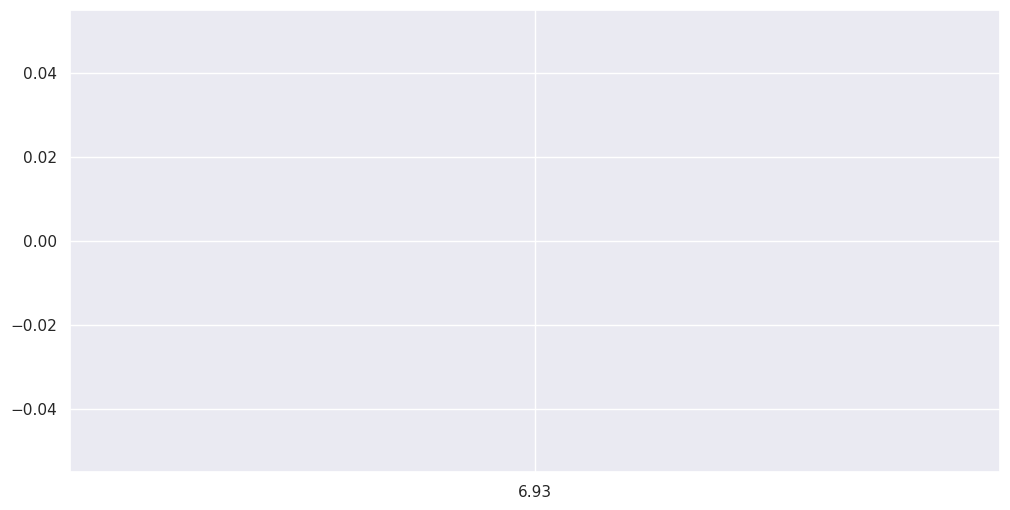

In [8]:
plot_temporal_expression(data)

In [ ]:
plot_cell_type_expression(data)

In [ ]:
plot_regional_expression(data)

In [ ]:
plot_temporal_cell_type_heatmap(data)

In [ ]:
# Basic statistics
print("\nSrrm3 Expression Statistics:")
print(f"Mean expression: {np.mean(data['Expression']):.4f}")
print(f"Median expression: {np.median(data['Expression']):.4f}")
print(f"Percentage of cells expressing Srrm3: {(data['Expression'] > 0).mean() * 100:.2f}%")

In [ ]:
# Top expressing cell types
df = pd.DataFrame({
    'Cell Type': data['Class'],
    'Expression': data['Expression']
})

print("\nTop 5 Cell Types by Mean Srrm3 Expression:")
print(df.groupby('Cell Type')['Expression']
        .agg(['mean', 'count'])
        .sort_values('mean', ascending=False)
        .head())

In [5]:
print(np.__version__)




1.24.3
